# Data Preprocessing

In [1]:
!pip install keras_applications

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
import cv2
warnings.filterwarnings("ignore")
from numpy.random import permutation
np.random.seed(2016)
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPool2D # GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras import utils
from keras.models import model_from_json
from sklearn.metrics import log_loss, confusion_matrix
from keras import regularizers
import h5py

from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
# from keras.layers.advanced_activations import LeakyReLU
from sklearn.metrics import confusion_matrix

from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, \
    GlobalAveragePooling2D, Dense, BatchNormalization, Activation, Conv2D
from keras.models import Model
# from keras.engine.topology import get_source_inputs
from keras.losses import CategoricalCrossentropy
from keras.utils import get_source_inputs, plot_model
# from depthwise_conv2d import DepthwiseConvolution2D

/home/amirhossein_sr/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2024-03-16 15:39:53.019605: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-16 15:39:53.065901: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 15:39:53.065942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cu

In [3]:
use_cache = 1
dataset_path = r'../Dataset/'
np.random.seed(2016)
warnings.filterwarnings("ignore")

In [4]:
def get_im_cv2(path):
    img = cv2.imread(path)
    resized = cv2.resize(src=img, dsize=(224, 224), interpolation=cv2.INTER_LINEAR) / 255.0
    return resized

In [5]:
def load_train():
    df = pd.read_csv(dataset_path + 'auc.distracted.driver.train.csv')
    x = df.iloc[:,0]
    y = df.iloc[:,1]
    X_train = []
    Y_train = []
    print('Read train images')
    for i in range (0,len(x)):
        fl= dataset_path + r'v1_cam1_no_split/' + r'/'.join(x[i].split('/')[-2:])
        print(f"Reading image {i}/{len(x)}")
        img = get_im_cv2(fl)
        X_train.append(img)
        Y_train.append(y[i])
    return X_train, Y_train

In [6]:
def load_train():
    classes = os.listdir(dataset_path + 'v1_cam1_no_split')
    X_train = []
    Y_train = []

    print('Read train images')
    for class_name in classes:
        class_path = dataset_path + r'v1_cam1_no_split/' + class_name
        if os.path.isdir(class_path):
            print(f"Reading Floder {class_name}...")
            image_filenames = os.listdir(class_path)
            for image_filename in image_filenames:
                image_path = class_path + r'/' + image_filename
                image = get_im_cv2(image_path)
                X_train.append(image)
                Y_train.append(classes.index(class_name))
    return X_train, Y_train

In [7]:
def load_valid():
    df = pd.read_csv(dataset_path + 'auc.distracted.driver.test.csv')
    x = df.iloc[:,0]
    y = df.iloc[:,1]
    X_valid = []
    Y_valid = []
    print('Read test images')
    for i in range (0,len(x)):
        fl = dataset_path + r'v1_cam1_no_split/' + r'/'.join(x[i].split('/')[-2:])
        print(f"Reading image {i}/{len(x)}")
        img = get_im_cv2(fl)
        X_valid.append(img)
        Y_valid.append(y[i])
    return X_valid, Y_valid

In [8]:
def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()
    else:
        print('Directory doesnt exists')

In [9]:
def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data

In [10]:
def read_and_normalize_train_data():
    cache_path = r'../Dataset/cache/train_v1.dat'
    if not os.path.isfile(cache_path) or use_cache == 0:
        train_data, train_target= load_train()
        cache_data((train_data, train_target), cache_path)
    else:
        print('Restore train from cache!')
        (train_data, train_target) = restore_data(cache_path)
    
    print('Convert to numpy...')
    train_data = np.array(train_data, dtype=np.uint8)
    train_target = np.array(train_target, dtype=np.uint8)
    
    print('Reshape...')
    train_data = train_data.transpose((0, 1, 2, 3))

    # Normalise the train data
    print('Convert to float...')
    train_data = train_data.astype('float16')
    mean_pixel = [80.857, 81.106, 82.928]
    
    print('Substract 0...')
    train_data[:, :, :, 0] -= mean_pixel[0]
    
    print('Substract 1...')
    train_data[:, :, :, 1] -= mean_pixel[1]

    print('Substract 2...')
    train_data[:, :, :, 2] -= mean_pixel[2]

    train_target = utils.to_categorical(train_target, 10)
    
    # Shuffle experiment START !!
    perm = permutation(len(train_target))
    train_data = train_data[perm]
    train_target = train_target[perm]
    # Shuffle experiment END !!
    
    print('Train shape:', train_data.shape)
    print(train_data.shape[0], 'train samples')
    print('Target shape:', train_target.shape)
    print(train_target.shape[0], 'target samples')
    return train_data, train_target

In [11]:
def read_and_normalize_test_data():
    start_time = time.time()
    cache_path = r'../Dataset/cache/test_v1.dat'

    if not os.path.isfile(cache_path) or use_cache == 0:
        test_data, test_target = load_valid()
        cache_data((test_data, test_target ), cache_path)
    else:
        print('Restore test from cache [{}]!')
        (test_data, test_target) = restore_data(cache_path)

    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.transpose((0, 1, 2, 3))

    # Normalise the test data data

    test_data = test_data.astype('float16')
    mean_pixel = [80.857, 81.106, 82.928]

    test_data[:, :, :, 0] -= mean_pixel[0]

    test_data[:, :, :, 1] -= mean_pixel[1]

    test_data[:, :, :, 2] -= mean_pixel[2]

    test_target = utils.to_categorical(test_target, 10)
    print('Test shape:', test_data.shape)
    print(test_data.shape[0], 'test samples')
    print('Target shape:', test_target.shape)
    print(test_target.shape[0], 'target samples')
    print('Read and process test data time: {} seconds'.format(round(time.time() - start_time, 2)))
    return test_data, test_target

In [12]:
X_train, Y_train = read_and_normalize_train_data()
X_valid, Y_valid = read_and_normalize_test_data()

Restore train from cache!
Convert to numpy...
Reshape...
Convert to float...
Substract 0...
Substract 1...
Substract 2...
Train shape: (12977, 224, 224, 3)
12977 train samples
Target shape: (12977, 10)
12977 target samples
Restore test from cache [{}]!
Test shape: (4331, 224, 224, 3)
4331 test samples
Target shape: (4331, 10)
4331 target samples
Read and process test data time: 10.55 seconds


# Model Execution

In [13]:
batch_size = 64
nb_epoch = 180

In [14]:
def VGG_16(input_shape=(224,224,3), classes=10):

    img_input = Input(shape =input_shape)
    print(img_input)

    # 1st Conv Block

    x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(img_input)
    x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
    x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

    # 2nd Conv Block

    x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
    x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

    # 3rd Conv block

    x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
    x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
    x = Dropout(0.1)(x)
 
    # 4th Conv block

    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
    x = Dropout(0.2)(x)

    # 5th Conv block

    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
    x= Dropout(0.3)(x)

    # Last block

    x = Conv2D (filters =512, kernel_size =7, padding ='same', activation='relu')(x)
    x= Dropout(0.4)(x)
    x = Conv2D (filters =512, kernel_size =1, padding ='same', activation='relu')(x)
    x= Dropout(0.5)(x)
    x = Conv2D (filters =classes, kernel_size =1, padding ='same', activation='softmax')(x)
    output = GlobalAveragePooling2D()(x)

    # creating the model

    model = Model (inputs=img_input, outputs =output, name='VGG_16')
    model.summary()    

    # model.load_weights('weights.h5')
    opt = SGD(learning_rate=0.0001, momentum=0.9, weight_decay=10e-6)

    model.compile(opt, loss=CategoricalCrossentropy(), metrics=['accuracy'])
    return model

In [15]:
model = VGG_16()

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


2024-03-16 15:40:39.761479: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20024 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:17:00.0, compute capability: 8.6
2024-03-16 15:40:39.762333: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22480 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:65:00.0, compute capability: 8.6


Model: "VGG_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                            

In [16]:
# plot_model(model, show_shapes=True, show_layer_names=True)

In [17]:
weights_path=r'./Checkpoint/'       
callbacks = [ModelCheckpoint(weights_path, monitor='val_acc', save_best_only=True, verbose=1)]

print(X_train.shape)
hist = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_valid, Y_valid), use_multiprocessing=True, workers=16)

(12977, 224, 224, 3)
Epoch 1/180


2024-03-16 15:40:56.292433: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inVGG_16/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-16 15:40:56.683424: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-16 15:40:56.828489: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-16 15:40:58.781186: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-16 15:41:01.332867: I external/local_xla/xla/service/service.cc:168] XLA service 0x7c262b715e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-16 15:41:01.332901: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute

203/203 [==============================] - 117s 451ms/step - loss: 2.2281 - accuracy: 0.2047 - val_loss: 2.2217 - val_accuracy: 0.2129
Epoch 2/180
203/203 [==============================] - 71s 349ms/step - loss: 2.2170 - accuracy: 0.2129 - val_loss: 2.2241 - val_accuracy: 0.2129
Epoch 3/180
203/203 [==============================] - 71s 351ms/step - loss: 2.2160 - accuracy: 0.2128 - val_loss: 2.2193 - val_accuracy: 0.2129
Epoch 4/180
203/203 [==============================] - 71s 350ms/step - loss: 2.2148 - accuracy: 0.2128 - val_loss: 2.2181 - val_accuracy: 0.2129
Epoch 5/180
203/203 [==============================] - 70s 345ms/step - loss: 2.2119 - accuracy: 0.2131 - val_loss: 2.2160 - val_accuracy: 0.2129
Epoch 6/180
203/203 [==============================] - 69s 342ms/step - loss: 2.2118 - accuracy: 0.2131 - val_loss: 2.2105 - val_accuracy: 0.2129
Epoch 7/180
203/203 [==============================] - 69s 342ms/step - loss: 2.2101 - accuracy: 0.2127 - val_loss: 2.2127 - val_accura

In [18]:
pd.DataFrame(hist.history).to_csv(r'../Dataset/cache/try_hist.csv')

predictions_valid = model.predict(X_valid.astype('float32'), batch_size=batch_size, verbose=1)
cm1=confusion_matrix(Y_valid.argmax(axis=1), predictions_valid.argmax(axis=1))
ss=cm1[0,0]+cm1[1,1]+cm1[2,2]+cm1[3,3]+cm1[4,4]+cm1[5,5]+cm1[6,6]+cm1[7,7]+cm1[8,8]+cm1[9,9];
test_accuracy=np.divide(ss,4331);
print('Test Accuracy:',test_accuracy)

ppath=os.path.join('../Dataset/cache','confusion_mat.npy')
np.save(ppath, cm1)

68/68 [==============================] - 7s 95ms/step
Test Accuracy: 0.9071807896559686


In [19]:
def plot_history(history):

    def plot_result(metrics, labels, y_label, title, location):
        plt.plot(history.history[metrics[0]], label=labels[0])
        plt.plot(history.history[metrics[1]], label=labels[1])
        plt.title(title)
        plt.xlabel("Epoch")
        plt.ylabel(y_label)
        plt.legend(loc=location)
        # plt.savefig("/content/drive/MyDrive/proj/pic/MFCC_B128_E130_M30/" + title + ".png")
        plt.show()
        print("\n\n")
        
    # create accuracy sublpot
    plot_result(metrics=("accuracy", "val_accuracy"),
                 labels=("Train Accuracy", "Test Accuracy"),
                 y_label="Accuracy", title="Accuracy Evaluation", location="lower right")

    plot_result(metrics=("loss", "val_loss"),
                 labels=("Train Error", "Test Error"),
                 y_label="Loss", title="Error Evaluation", location="upper right")

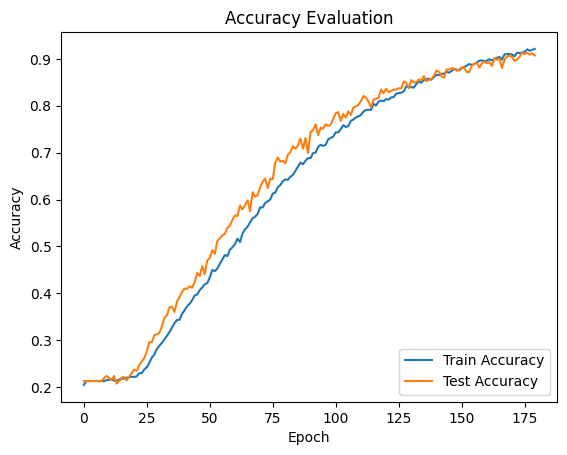

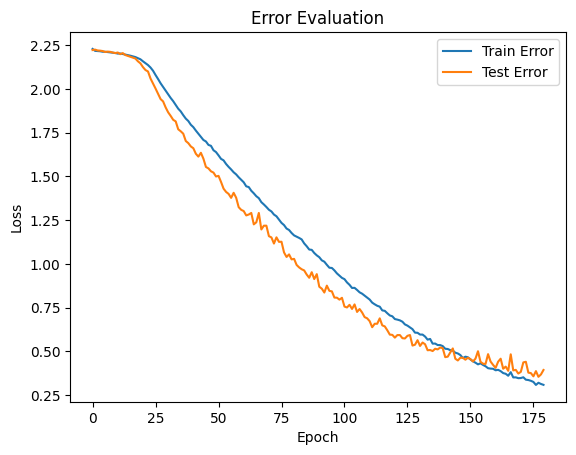

In [20]:
plot_history(hist)